In [ ]:
# read the eric weeks paper and answer:
    # what is the einstein vs debye diffusion
    # how do they compare rotational vs translational motion when the units differ

# cap angles for msad

# symmetrize the positions, to single state (by simple rotation) and measure extents of the cage
# non gaussian parameter - derive it to see what it means and how it relates to the diffusion coefficient and its time-independence
# measure diffusion in the generalized space (x, y, embed_1, embed_2)

# effective potential, modes, types of contacts, and actual friction (as compared to mu_eff)

# temperature scale of asperities (granular material isnt ever athermal bc asperity scale is small enough to have relevant thermal expansion)
# soft spot distribution in frictional glasses

In [1]:
# ---------------- IMPORTS FOR DIFFUSION ANALYSIS ----------------

import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.utils import join_systems, split_systems
from pydpmd.plot import draw_particles_frame, create_animation, downsample
import matplotlib.pyplot as plt
import subprocess
import os
from tqdm import tqdm
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import h5py
from matplotlib.colors import LogNorm

def embed_anbles(angle, angular_period, mask=None):
    if mask is None:
        mask = angular_period > 0
    new_angle = np.zeros_like(angle)
    new_angle[mask] = angle[mask] * 2 * np.pi / angular_period[mask]
    new_angle[~mask] = 0
    return np.column_stack([np.cos(new_angle), np.sin(new_angle)])

def compute_generalized_pos(pos, angle, system_id, angular_period, box_size=None, mask=None):
    if box_size is None:
        L = 1
    else:
        L = box_size[system_id]
    if mask is None:
        mask = angular_period > 0
    new_angle = np.zeros_like(angle)
    new_angle[mask] = angle[mask] * 2 * np.pi / angular_period[mask]
    new_angle[~mask] = 0
    return np.column_stack([pos / L, np.cos(new_angle), np.sin(new_angle)])


@requires_fields("pos", "angle")
def masked_fused_msd_kernel(indices, get_frame, system_id, system_size, mask):
    t0, t1 = indices
    r0 = get_frame(t0)['pos']
    r1 = get_frame(t1)['pos']
    theta0 = get_frame(t0)['angle']
    theta1 = get_frame(t1)['angle']
    dr = r1 - r0
    msd = np.bincount(system_id, weights=np.sum(dr ** 2, axis=-1)) / system_size
    dtheta = (theta1 - theta0) * mask
    angular_msd = np.bincount(system_id, weights=dtheta ** 2) / system_size
    return np.column_stack([msd, angular_msd])

@requires_fields("pos", "angle")
def fused_generalized_msd_kernel(indices, get_frame, system_id, system_size, angular_period, box_size):
    t0, t1 = indices
    r0 = get_frame(t0)['pos']
    r1 = get_frame(t1)['pos']
    theta0 = get_frame(t0)['angle']
    theta1 = get_frame(t1)['angle']
    gen_pos0 = compute_generalized_pos(r0, theta0, system_id, angular_period, box_size)
    gen_pos1 = compute_generalized_pos(r1, theta1, system_id, angular_period, box_size)
    dr = gen_pos1 - gen_pos0
    msd = np.bincount(system_id, weights=np.sum(dr ** 2, axis=-1)) / system_size
    return msd

@requires_fields("pos", "angle")
def fused_msd_generalized_angular_msd_kernel(indices, get_frame, system_id, system_size, angular_period, box_size):
    t0, t1 = indices
    r0 = get_frame(t0)['pos']
    r1 = get_frame(t1)['pos']
    theta0 = get_frame(t0)['angle']
    theta1 = get_frame(t1)['angle']
    gen_theta0 = embed_anbles(theta0, angular_period)
    gen_theta1 = embed_anbles(theta1, angular_period)
    dr = r1 - r0
    msd = np.bincount(system_id, weights=np.sum(dr ** 2, axis=-1)) / system_size
    dtheta = gen_theta1 - gen_theta0
    angular_msd = np.bincount(system_id, weights=np.sum(dtheta ** 2, axis=-1)) / system_size
    return np.column_stack([msd, angular_msd])

def load_state_h5(path):
    out = {}
    with h5py.File(path, 'r') as f:
        for name in f.keys():
            g = f[name]
            out[float(name)] = {
                'pos': g['pos'][:],
                'angle': g['angle'][:],
                'delta_phi': float(g.attrs['delta_phi']),
                'packing_fraction': float(g.attrs['packing_fraction']),
                'n_samples': int(g.attrs['n_samples']),
                'n_valid_samples': int(g.attrs['n_valid_samples']),
                'box_size': g['box_size'][:],
            }
    return out

In [67]:
# ---------------- IMPORTS FOR STATE ANALYSIS ----------------

from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp

def unwrap(phi):
    return (phi + 2*np.pi) % (2*np.pi)

def flatten_arr(arr):
    if arr.ndim < 3:
        arr = arr[..., None]
    arr_flat = np.zeros((arr.shape[0], arr.shape[1] * arr.shape[2]))
    for i in range(arr.shape[2]):
        arr_flat[:, i::arr.shape[2]] = arr[:, :, i]
    return arr_flat

def embed_angle(angle, angle_period):
    norm_angle = np.zeros_like(angle)
    norm_angle[angle_period > 0] = 2 * np.pi * angle[angle_period > 0] / angle_period[angle_period > 0]
    return np.column_stack((np.cos(norm_angle), np.sin(norm_angle)))

def embed_pos(_pos, _angle, _angle_period):
    """
    concatenates the positions and embedded angles to a generalized 4 * N_particles-dimensional configuration space
    _pos: (N_samples, N_particles, 2)
    _angle: (N_samples, N_particles)
    _angle_period: (N_samples, N_particles)
    returns: (N_samples, N_particles * 4)
    """
    pos = flatten_arr(_pos)
    angle = flatten_arr(_angle)
    angle_period = flatten_arr(_angle_period)

    N_particles = pos.shape[1] // 2
    N_dim_per_particle = 4
    generalized_pos = np.zeros((pos.shape[0], N_particles * N_dim_per_particle))  # x, y, cos(theta), sin(theta)
    for i in range(N_particles):
        gi = i * N_dim_per_particle
        generalized_pos[:, gi:gi + 2] = pos[:, i * 2:i * 2 + 2]
        generalized_pos[:, gi + 2:gi + 4] = embed_angle(angle[:, i], angle_period[:, i])
    return generalized_pos

def unembed_pos(arr, angle_period):
    single_sample = arr.ndim == 1
    if single_sample:
        arr = arr[None, :]
        angle_period = angle_period[None, :]

    N_dims_per_particle = 4
    N_particles = arr.shape[1] // N_dims_per_particle

    pos = np.zeros((arr.shape[0], N_particles, 2))
    angle = np.zeros((arr.shape[0], N_particles))

    for i in range(N_particles):
        pos[:, i, :] = arr[:, i * N_dims_per_particle: (i + 1) * N_dims_per_particle - 2]
        angle[:, i] = unwrap(np.arctan2(arr[:, i * N_dims_per_particle + 3], arr[:, i * N_dims_per_particle + 2])) * angle_period[:, i] / (2 * np.pi)
    if single_sample:
        pos = pos[0]
        angle = angle[0]
    return pos, angle

def get_cluster_labels(generalized_pos, k, radius=1e-8):
    nn = NearestNeighbors(n_neighbors=k + 1, algorithm='kd_tree', radius=radius)
    nn.fit(generalized_pos)
    dist, idx = nn.kneighbors(generalized_pos, return_distance=True)
    row, col = [], []
    for i in range(len(generalized_pos)):
        nbrs = idx[i][1:]
        row.extend([i]*k)
        col.extend(nbrs)
    data = np.ones(len(row), dtype=bool)
    G = sp.csr_matrix((data, (row, col)), shape=(len(generalized_pos), len(generalized_pos)))
    G = G + G.T
    n_components, labels = sp.csgraph.connected_components(G, directed=False)
    return labels, n_components

def safe_mod(arr, mod_period):
    mod = np.zeros_like(arr)
    mod[mod_period > 0] = np.mod(arr[mod_period > 0], mod_period[mod_period > 0])
    return mod

def symmetrize_pos(pos, angle, angle_period, box_size, k_fold_symmetry, vpos=None):
    # symmetrize the positions and angles and pick the representation where particle 0 is closest to the origin
    sym_angle = 2 * np.pi / k_fold_symmetry
    rot_angle = []
    rot_pos = []
    rot_vpos = []
    for k in range(0, k_fold_symmetry):
        t = k * sym_angle
        rot_angle.append(safe_mod(angle + t, angle_period))
        R = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
        rot_pos.append(np.einsum('ij,nmj->nmi', R, pos - box_size / 2) + box_size / 2)
        if vpos is not None:
            rot_vpos.append(np.einsum('ij,nmj->nmi', R, vpos - box_size / 2) + box_size / 2)
    rot_pos = np.array(rot_pos)
    rot_angle = np.array(rot_angle)

    # choose the representation where particle 0 is closest to the origin
    indices = np.argmin(np.linalg.norm(rot_pos[:, :, 0], axis=-1), axis=0)

    final_angle = np.array([rot_angle[i_rep, i] for i, i_rep in enumerate(indices)])
    final_pos = np.array([rot_pos[i_rep, i] for i, i_rep in enumerate(indices)])
    if vpos is not None:
        rot_vpos = np.array(rot_vpos)
        final_vpos = np.array([rot_vpos[i_rep, i] for i, i_rep in enumerate(indices)])

    assert final_angle.shape == angle.shape
    assert final_pos.shape == pos.shape
    if vpos is not None:
        return final_pos, final_angle, final_vpos
    return final_pos, final_angle

def get_angular_extent(clustered_angles):
    # assumes that the angles form a continuous cluster and are normalized to [0, 2pi)
    # finds the total angular extent of the cluster
    s = np.sort(clustered_angles)
    gaps = np.diff(np.r_[s, s[0] + 2*np.pi])  # get the gaps between the sorted angles and the first angle plus 2pi
    return 2*np.pi - np.max(gaps)  # get the total extent of the cluster

def get_translational_extent(clustered_pos):
    return np.linalg.norm(np.max(clustered_pos, axis=0) - np.min(clustered_pos, axis=0), axis=-1)

def get_extents_from_state(state):
    angular_extent = []
    translational_extent = []
    delta_phi = []
    max_size = int(1e4)
    for i in tqdm(state.keys()):
        pos = state[i]['pos'].copy()
        angle = state[i]['angle'].copy()
        angle_period =  np.array([data.angular_period[:2] for i in range(pos.shape[0])])
        box_size = state[i]['box_size'].copy()

        pos_final, angle_final = symmetrize_pos(pos, angle, angle_period, box_size, 4)
        gen_pos_final = embed_pos(pos_final, angle_final, angle_period)
        if pos_final.shape[0] < 10:
            continue
        if pos_final.shape[0] > max_size:
            pos_final = pos_final[:max_size]
            angle_final = angle_final[:max_size]
            gen_pos_final = gen_pos_final[:max_size]
        labels, n_components = get_cluster_labels(gen_pos_final, int(0.01 * pos_final.shape[0]) + 10, 1e-8)

        if n_components > 1:
            print('multiple clusters found')
        cid = 0
        angles = angle_final[labels == cid].copy()
        angular_extent.append(np.array([get_angular_extent(angles[:, i]) for i in range(angles.shape[1])]))
        translational_extent.append(get_translational_extent(pos_final[labels == cid]))
        delta_phi.append(state[i]['delta_phi'])
    return np.array(angular_extent), np.array(translational_extent), np.array(delta_phi)

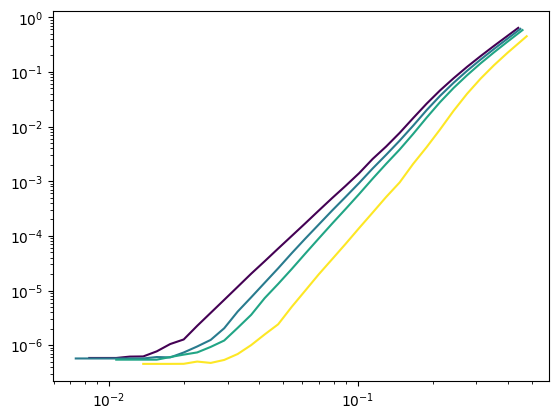

In [89]:
data_root = "/home/mmccraw/dev/data/09-09-25/bumpy-final"
mu_eff_paths = [p for p in os.listdir(data_root) if '0.' in p]
mu_eff_scalars = np.array([float(p) for p in mu_eff_paths])
mu_eff_paths = np.array(mu_eff_paths)[np.argsort(mu_eff_scalars)]
mu_eff_scalars = mu_eff_scalars[np.argsort(mu_eff_scalars)]

cmap = plt.cm.viridis
mu_eff_norm = LogNorm(vmin=mu_eff_scalars.min(), vmax=mu_eff_scalars.max())

for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    try:
        state = load_state_h5(os.path.join(path, "box_sample_result.h5"))
        data = load(os.path.join(path, "offset"), location=['init', 'final'])
    except Exception as e:
        print(e)
        print(path)
        continue
    plt.plot([v['delta_phi'] for v in state.values()], [(v['n_valid_samples'] / v['n_samples']) * np.prod(state[30]['box_size'] - 2 * 0.5 * data.vertex_rad.max()) for v in state.values()], c=cmap(mu_eff_norm(mu_eff_scalars[i])))
plt.xscale('log')
plt.yscale('log')


array([0.01765308, 0.01765308])

 42%|████▏     | 14/33 [00:00<00:00, 82.70it/s]

100%|██████████| 28/28 [00:05<00:00,  4.80it/s] 


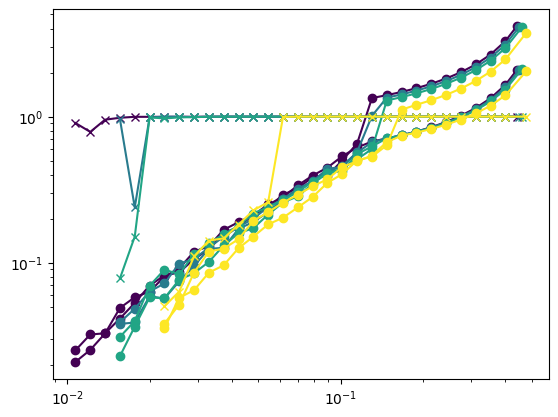

In [131]:
translational_extent_dphi = []
rotational_extent_dphi = []
for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    try:
        state = load_state_h5(os.path.join(path, "box_sample_result.h5"))
        data = load(os.path.join(path, "offset"), location=['init', 'final'])
        dphi_unique = np.unique(data.delta_phi)
        angular_extent, translational_extent, dphi = get_extents_from_state(state)
        translational_extent_dphi.append(np.concatenate([
            dphi_unique[np.argmax(np.diff(translational_extent, axis=0), axis=0)],
            [float(mu_eff)],
        ]))
        rotational_extent_dphi.append(np.concatenate([
            dphi_unique[np.argmax(np.diff(angular_extent, axis=0), axis=0)],
            [float(mu_eff)],
        ]))
    except Exception as e:
        print(e)
        print(path)
        continue
    norm_angular_extent = angular_extent.copy()
    ang_per = data.angular_period[:2]
    norm_angular_extent[:, ang_per > 0] /= ang_per[ang_per > 0]
    plt.plot(dphi, translational_extent, c=cmap(mu_eff_norm(mu_eff_scalars[i])), marker='o')
    plt.plot(dphi, norm_angular_extent, c=cmap(mu_eff_norm(mu_eff_scalars[i])), marker='x')
plt.xscale('log')
plt.yscale('log')
plt.show()

translational_extent_dphi = np.array(translational_extent_dphi)
rotational_extent_dphi = np.array(rotational_extent_dphi)

In [ ]:
# measure ballistic slope

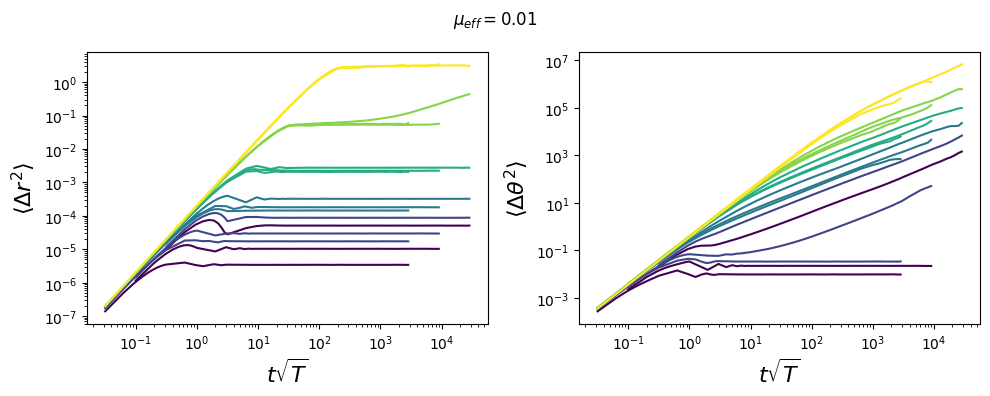

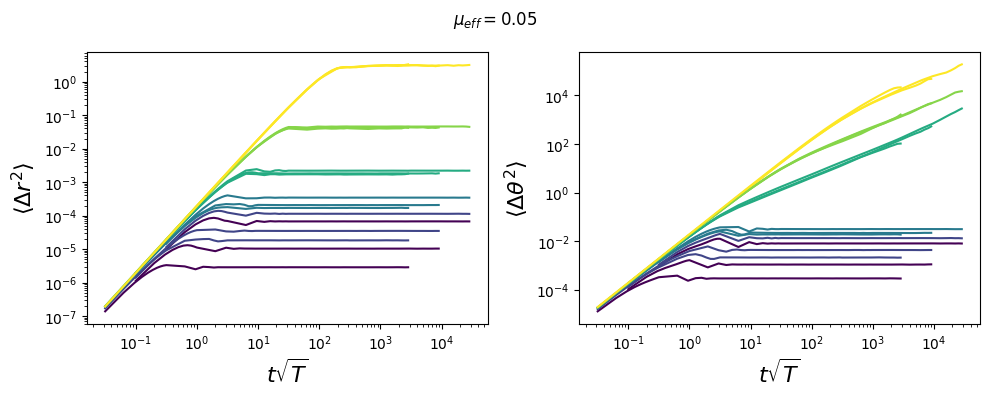

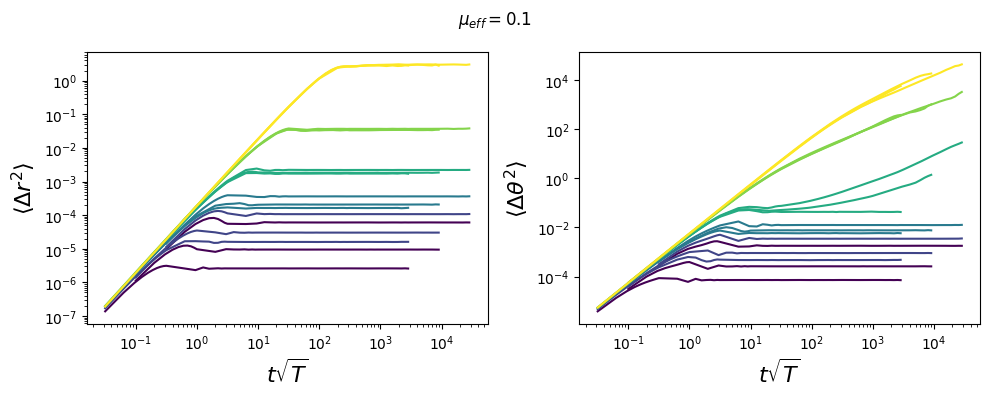

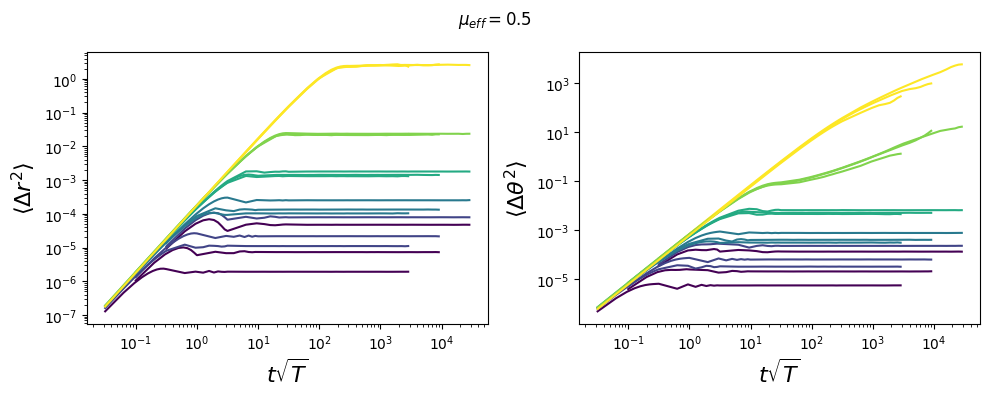

In [111]:
d_data = []

for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for T in ['1e-05', '1e-06', '1e-07']:
        T_fl = float(T)
        data_path = os.path.join(path, f'dynamics_{T}')
        msd_path = data_path + '_msd.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])
        d_data.append(
            np.concatenate([
                np.unique(data.delta_phi)[np.argmax(np.diff(np.log10(np.mean(msd[:, -10:, :], axis=1)), axis=0), axis=0)],
                [float(mu_eff)],
                [float(T_fl)],
            ])
        )
        dphi_unique = np.unique(data.delta_phi)
        norm = LogNorm(vmin=dphi_unique.min(), vmax=dphi_unique.max())
        for i in [0, 10, 20, 30, 40, 49]:
            ax[0].plot(t * np.sqrt(T_fl), msd[i, :, 0], c=cmap(norm(dphi_unique[i])))
            ax[1].plot(t * np.sqrt(T_fl), msd[i, :, 1], c=cmap(norm(dphi_unique[i])))
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$t \sqrt{T}$', fontsize=16)
    plt.suptitle(r'$\mu_{eff}=$' + f'{mu_eff}')
    ax[0].set_ylabel(r'$\langle \Delta r^2 \rangle$', fontsize=16)
    ax[1].set_ylabel(r'$\langle \Delta \theta^2 \rangle$', fontsize=16)
    plt.tight_layout()
    plt.show()

d_data = np.array(d_data)

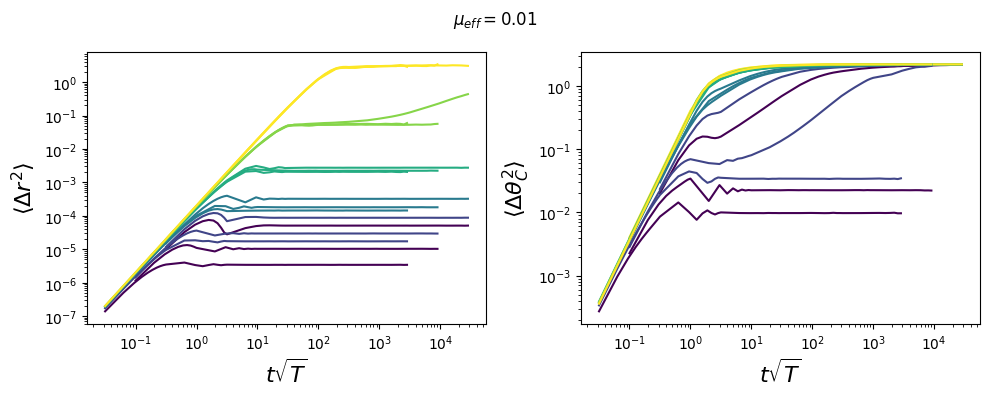

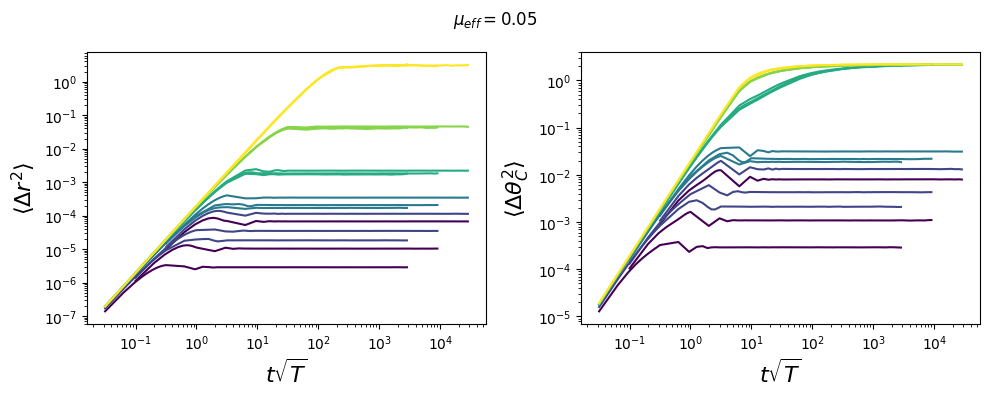

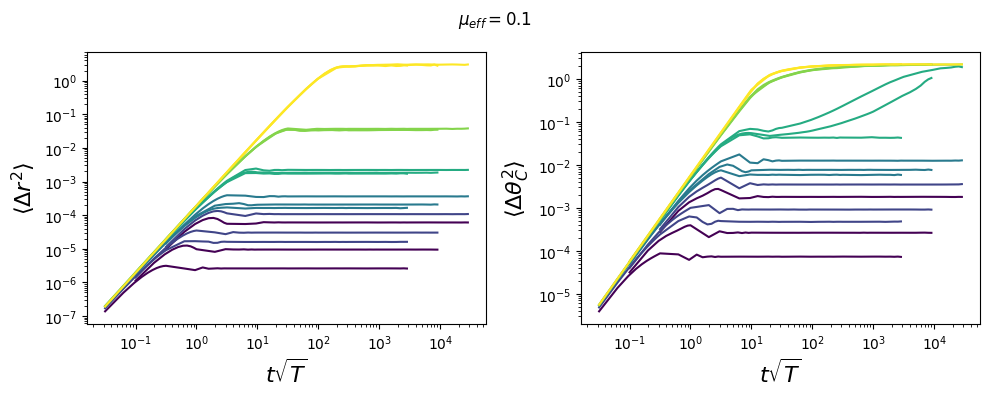

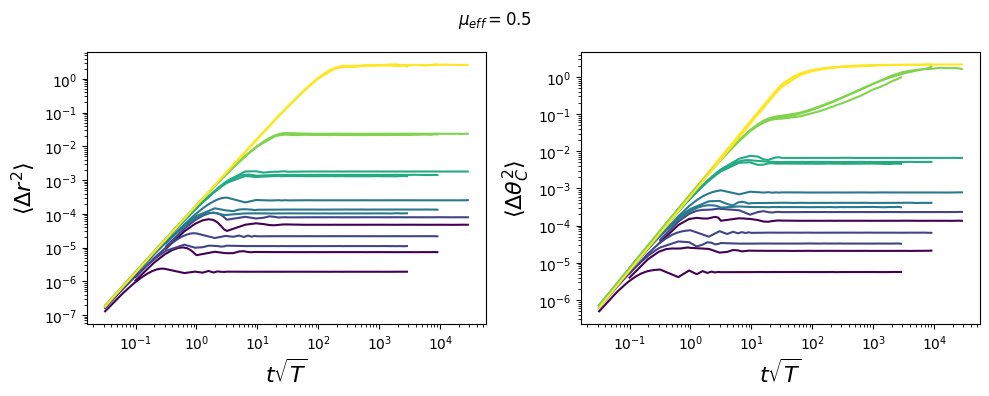

In [124]:
for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for T in ['1e-05', '1e-06', '1e-07']:
        T_fl = float(T)
        data_path = os.path.join(path, f'dynamics_{T}')
        msd_path = data_path + '_msd.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])
        dphi_unique = np.unique(data.delta_phi)
        norm = LogNorm(vmin=dphi_unique.min(), vmax=dphi_unique.max())
        for i in [0, 10, 20, 30, 40, 49]:
            ax[0].plot(t * np.sqrt(T_fl), msd[i, :, 0], c=cmap(norm(dphi_unique[i])))

        msd_path = data_path + '_capped_msad.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])
        for i in [0, 10, 20, 30, 40, 49]:
            ax[1].plot(t * np.sqrt(T_fl), msd[i, :], c=cmap(norm(dphi_unique[i])))

    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$t \sqrt{T}$', fontsize=16)
    plt.suptitle(r'$\mu_{eff}=$' + f'{mu_eff}')
    ax[0].set_ylabel(r'$\langle \Delta r^2 \rangle$', fontsize=16)
    ax[1].set_ylabel(r'$\langle \Delta \theta_C^2 \rangle$', fontsize=16)
    plt.tight_layout()
    plt.show()

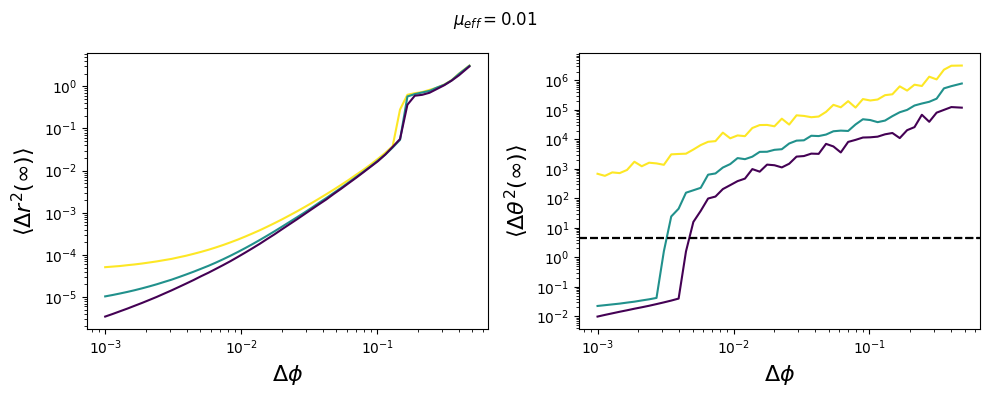

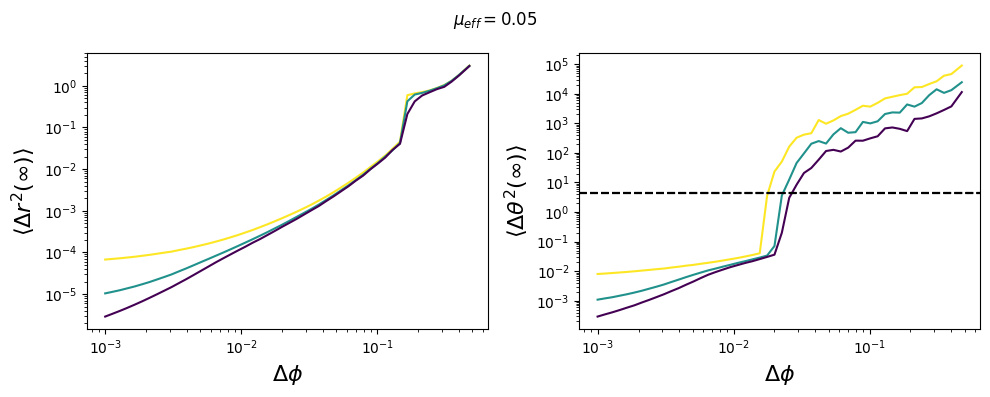

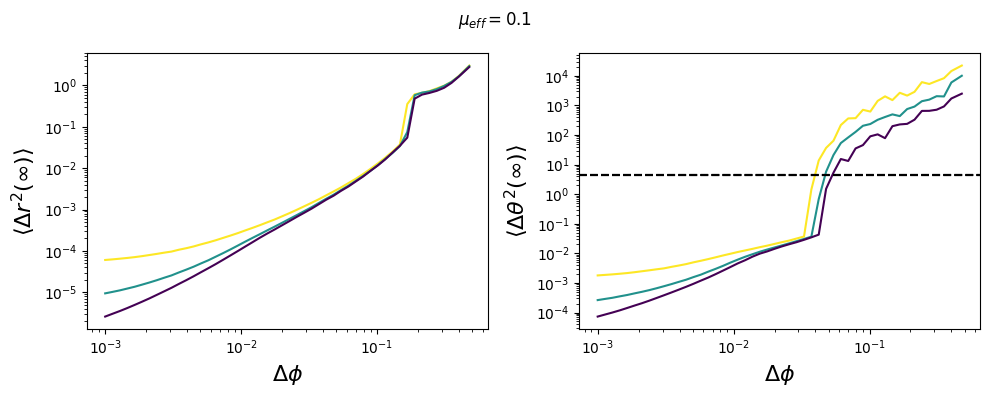

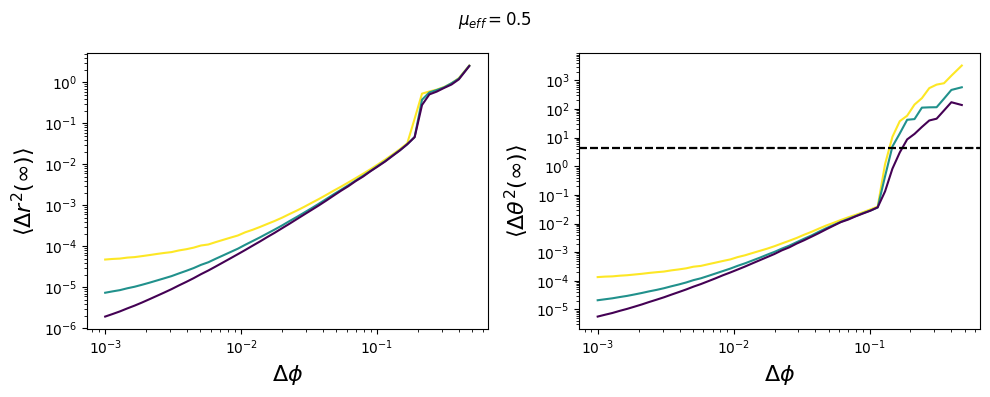

In [120]:
for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    norm = LogNorm(vmin=1e-7, vmax=1e-5)
    cmap = plt.cm.viridis
    for T in ['1e-05', '1e-06', '1e-07']:
        T_fl = float(T)
        data_path = os.path.join(path, f'dynamics_{T}')
        msd_path = data_path + '_msd.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])

        ax[0].plot(dphi_unique, np.mean(msd[:, -10:, :], axis=1)[:, 0], c=cmap(norm(T_fl)))
        ax[1].plot(dphi_unique, np.mean(msd[:, -10:, :], axis=1)[:, 1], c=cmap(norm(T_fl)))
        ax[1].axhline(data.angular_period[0] ** 2, c='k', linestyle='--')
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$\Delta \phi$', fontsize=16)
    plt.suptitle(r'$\mu_{eff}=$' + f'{mu_eff}')
    ax[0].set_ylabel(r'$\langle \Delta r^2 (\infty) \rangle$', fontsize=16)
    ax[1].set_ylabel(r'$\langle \Delta \theta^2 (\infty) \rangle$', fontsize=16)
    plt.tight_layout()
    plt.show()

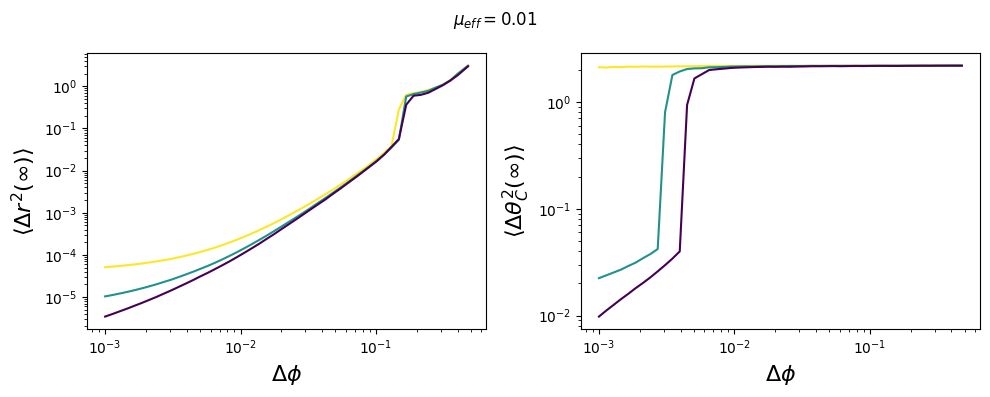

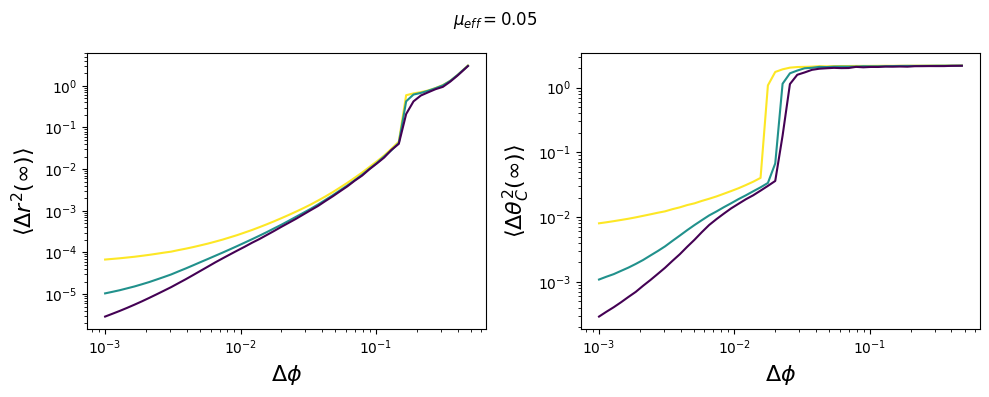

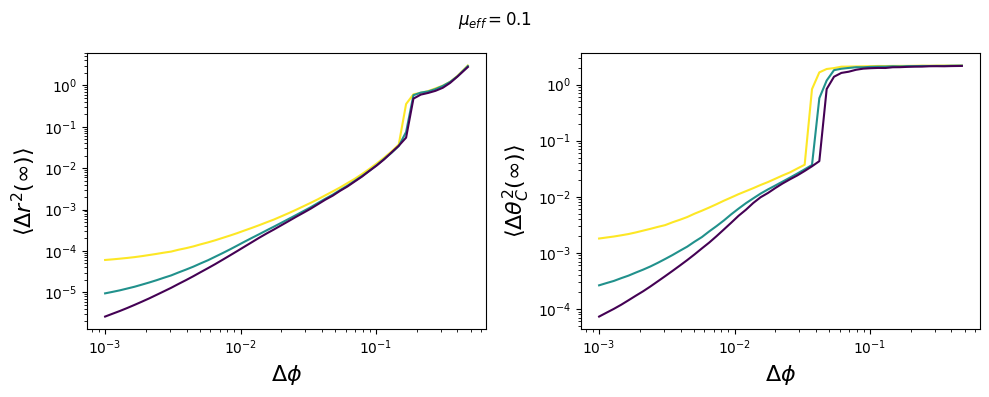

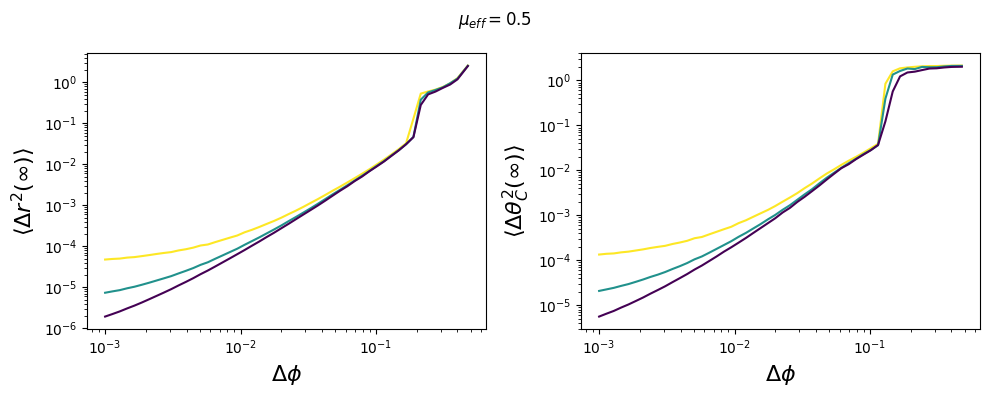

In [122]:
for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    norm = LogNorm(vmin=1e-7, vmax=1e-5)
    cmap = plt.cm.viridis
    for T in ['1e-05', '1e-06', '1e-07']:
        T_fl = float(T)
        data_path = os.path.join(path, f'dynamics_{T}')
        msd_path = data_path + '_msd.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])

        ax[0].plot(dphi_unique, np.mean(msd[:, -10:, :], axis=1)[:, 0], c=cmap(norm(T_fl)))

        msd_path = data_path + '_capped_msad.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])

        ax[1].plot(dphi_unique, np.mean(msd[:, -10:], axis=1), c=cmap(norm(T_fl)))
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel(r'$\Delta \phi$', fontsize=16)
    plt.suptitle(r'$\mu_{eff}=$' + f'{mu_eff}')
    ax[0].set_ylabel(r'$\langle \Delta r^2 (\infty) \rangle$', fontsize=16)
    ax[1].set_ylabel(r'$\langle \Delta \theta_C^2 (\infty) \rangle$', fontsize=16)
    plt.tight_layout()
    plt.show()

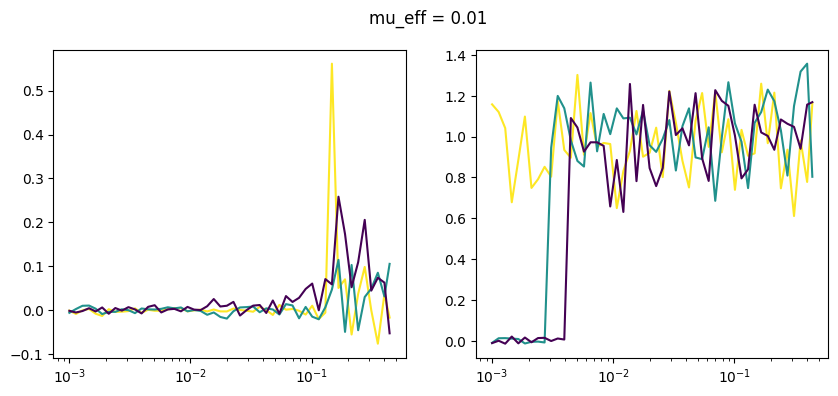

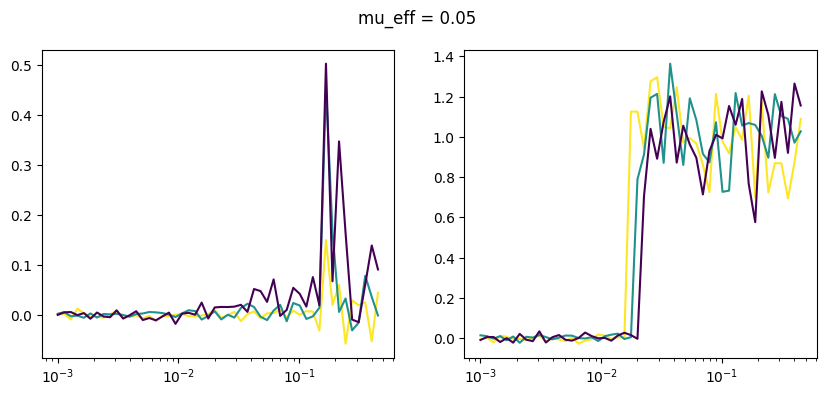

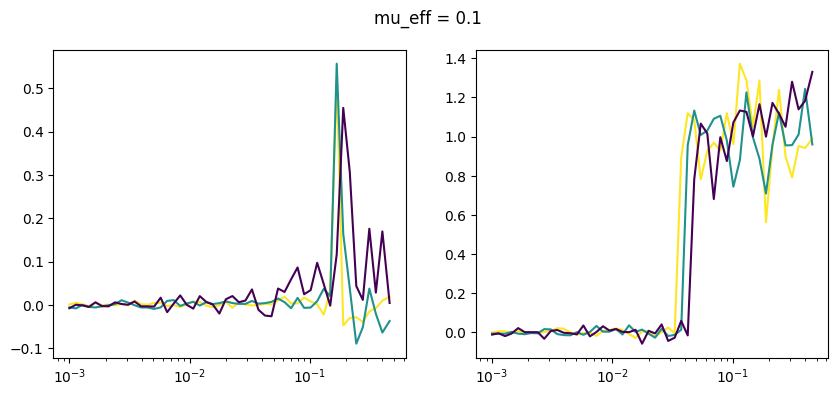

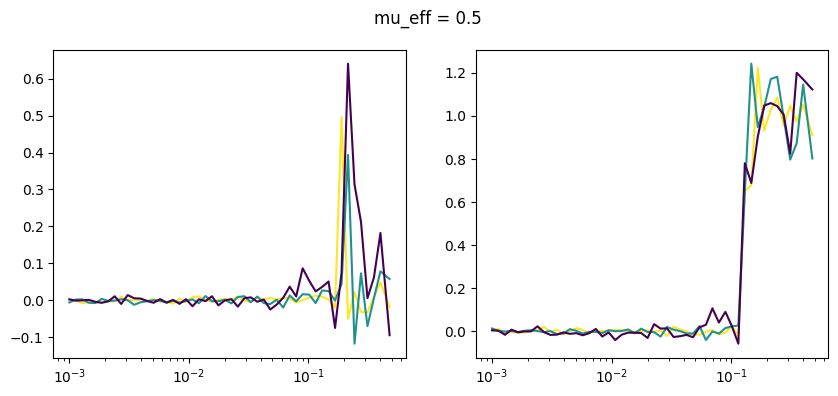

In [123]:
for i, mu_eff in enumerate(mu_eff_paths):
    path = os.path.join(data_root, mu_eff)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    T_norm = LogNorm(vmin=1e-7, vmax=1e-5)
    cmap = plt.cm.viridis
    for T in ['1e-05', '1e-06', '1e-07']:
        T_fl = float(T)
        data_path = os.path.join(path, f'dynamics_{T}')
        msd_path = data_path + '_msd.npz'
        data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=False)
        msd_data = np.load(msd_path)
        t = msd_data['t']
        ids = msd_data['ids']
        msd = np.array([np.mean(msd_data['msd'][:, ids == i], axis=1) for i in np.unique(ids)])

        last_10_msd = np.log10(msd[:, -10:, :])
        last_10_t = np.log10(t[-10:])
        slopes = (last_10_msd[:, 1:] - last_10_msd[:, :-1]) / (last_10_t[1:] - last_10_t[:-1])[None, :, None]
        dphi_unique = np.unique(data.delta_phi)
        ax[0].plot(dphi_unique, np.mean(slopes, axis=1)[:, 0], c=cmap(T_norm(T_fl)))
        ax[1].plot(dphi_unique, np.mean(slopes, axis=1)[:, 1], c=cmap(T_norm(T_fl)))
    for a in ax:
        a.set_xscale('log')
    plt.suptitle(f'mu_eff = {mu_eff}')
    plt.show()

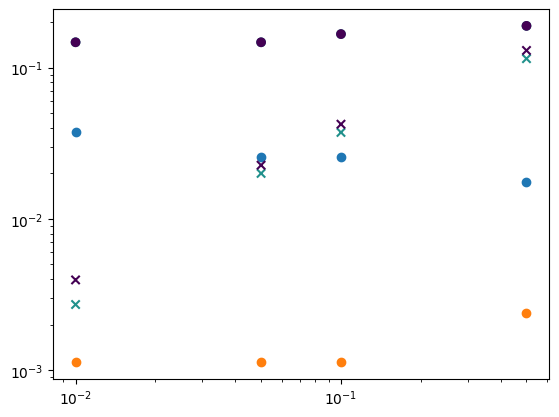

In [137]:
plt.scatter(translational_extent_dphi[:, 2], translational_extent_dphi[:, 0])
plt.scatter(rotational_extent_dphi[:, 2], rotational_extent_dphi[:, 0])

mask = d_data[:, 3] < 1e-5
plt.scatter(d_data[mask, 2], d_data[mask, 0], c=cmap(T_norm(d_data[mask, 3])))
plt.scatter(d_data[mask, 2], d_data[mask, 1], c=cmap(T_norm(d_data[mask, 3])), marker='x')

plt.xscale('log')
plt.yscale('log')

In [ ]:
# delta_phi_T, delta_phi_R, mu_eff, T
mask = d_data[:, 3] < 1e-5
plt.scatter(d_data[mask, 2], d_data[mask, 0], c=cmap(T_norm(d_data[mask, 3])))
plt.scatter(d_data[mask, 2], d_data[mask, 1], c=cmap(T_norm(d_data[mask, 3])), marker='x')
plt.xscale('log')
plt.yscale('log')

In [ ]:
data = load(data_path, location=['init', 'final'], load_trajectory=True, load_full=True)

In [ ]:
dphi_unique, ids = np.unique(data.delta_phi, return_inverse=True)

ke_total_t = np.mean(data.trajectory.ke_total, axis=0)
ke_total_t = np.array([np.mean(ke_total_t[ids == i]) for i in np.unique(ids)])

pe_total_t = np.mean(data.trajectory.pe_total, axis=0)
pe_total_t = np.array([np.mean(pe_total_t[ids == i]) for i in np.unique(ids)])

te_total_t = ke_total_t + pe_total_t

ke_t = np.mean(0.5 * np.sum(data.trajectory.vel ** 2, axis=-1) * data.mass[None, :], axis=0)
ke_t = np.bincount(data.system_id, weights=ke_t)
ke_t = np.array([np.mean(ke_t[ids == i]) for i in np.unique(ids)])

ke_r = np.mean(0.5 * data.trajectory.angular_vel ** 2 * data.moment_inertia[None, :], axis=0)
ke_r = np.bincount(data.system_id, weights=ke_r)
ke_r = np.array([np.mean(ke_r[ids == i]) for i in np.unique(ids)])

temp = np.mean(data.trajectory.temperature, axis=0)
temp = np.array([np.mean(temp[ids == i]) for i in np.unique(ids)])

In [ ]:
plt.plot(dphi_unique, temp)
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(dphi_unique, ke_t)
plt.plot(dphi_unique, ke_r)
plt.xscale('log')
plt.yscale('log')